예측값: [12.]


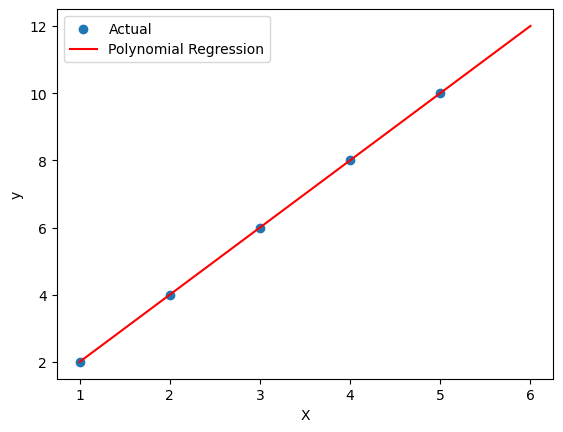

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# 입력 변수 생성
X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)

# 출력 변수 생성
y = np.array([2, 4, 6, 8, 10])

# 다항식 변환
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

# 다항 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)

# 예측을 위한 새로운 데이터 생성
X_new = np.array([6]).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)

# 예측
y_new = model.predict(X_new_poly)

# 결과 출력
print("예측값:", y_new)

# 다항 회귀 모델 시각화
X_plot = np.linspace(1, 6, 100).reshape(-1, 1)
X_plot_poly = poly_features.transform(X_plot)
y_plot = model.predict(X_plot_poly)

plt.scatter(X, y, label='Actual')
plt.plot(X_plot, y_plot, color='red', label='Polynomial Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import cv2

# Gaussian noise 
def gaussian_noise(x:list,
                   mu:float,
                   std:float)->np.ndarray:
    x_noisy = [x[i] + np.random.normal(mu,std,size=x[0].shape) for i in range(len(x))]
    return x_noisy

def solve_M(a,b,line_height=None):
    assert len(a) == len(b) and len(a) > 0
    
    # Prepare 'a' and 'b' w.r.t. the paper
    n = len(a)
    center = np.array([(cam_w - 1) / 2, (cam_h - 1) / 2])
    a = a - center
    b = b - center
    a = np.hstack((a, np.ones((n, 1)))) # To homogeneous notation
    b = np.hstack((b, np.ones((n, 1)))) #    (n x 2) to (n x 3)

    # Solve 'M @ v = 0 such that v > 0' in Equation (21)
    M = np.zeros((3*(n-1), 2*n), dtype=a.dtype)
    for i in range(1, n):
        s, e = (3*(i-1), 3*i)
        M[s:e, 0] = -a[0]
        M[s:e, i] = a[i]
        M[s:e, n] = b[0]
        M[s:e, n+i] = -b[i]
        
    
    # Mv = 0 
    _, _, Vh = np.linalg.svd(M)
    v = Vh[:][-1]
    lm, mu = v[:n, np.newaxis], v[n:, np.newaxis]
    return lm, mu 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


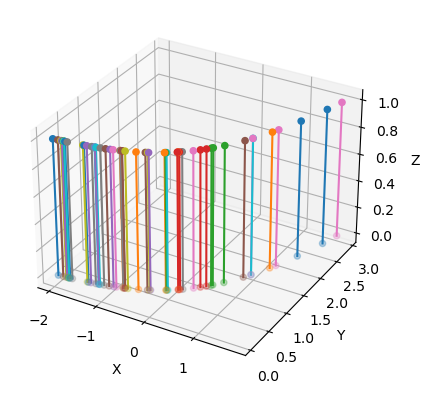

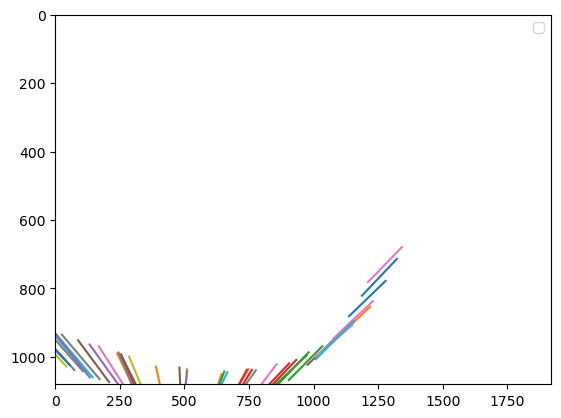

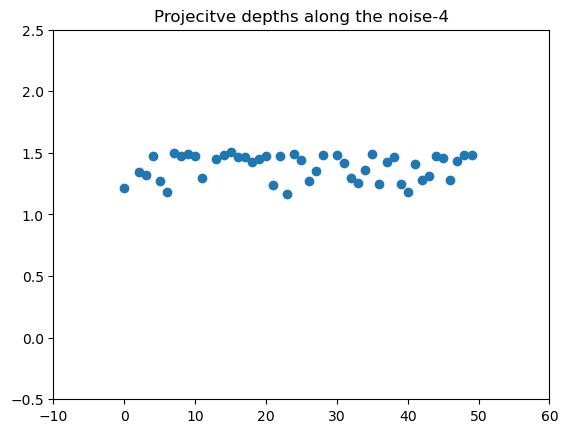

In [58]:
"""
This code is to explore the projective depth or depth ratios. 
To find relevant figures or key property for performance improvemnets is the goal. 
Therefore, this code goes as follows 
"""
#Define the test configuration
# The number of line segments 
n = 50
# Ground truth of focal length
cam_f = 800.
# Length of line segment 
l = 1  # [m]
# Position of camera
h = 3  # [m]
# Camera angle - theta#
theta_gt = np.deg2rad(40+90) 
# Camera angle - phi
phi_gt = np.deg2rad(30) 
# Vector of camera position
cam_pos = [0,0,h]  
# Resolution of the image
cam_w, cam_h =(1920, 1080)

traj = {"exp": lambda x: np.exp(x)**1/2, 
        "sin": lambda x: np.sin(x)**1/2, 
        "ran": lambda x: np.random.uniform(-1,5),
        "lin": lambda x: .5 * (x -1) }

# Generate lines randomly
lines =[]
for i in range(n):
    x = np.random.uniform(-2,2)
    y = traj["exp"](x)
    #y = np.random.uniform(2,15) # Working distance [mm->m]
    lines.append(np.array([[x,y,0],
                            [x,y,l]]))


#Visualize the line segments in 3d coordinate
fig = plt.figure()
ax =fig.add_subplot(projection ='3d')  
for idx,line in enumerate(lines):
    x,y,z =line[0:2,0],line[0:2,1],line[0:2,2] 
    ax.scatter(x,y,z)
    ax.plot(x,y,z, label=f'{idx}-th line')       
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.savefig(f"Trajectory of sin.pdf")



# Project two lines
Rz = np.array([[np.cos(phi_gt), -np.sin(phi_gt), 0], [np.sin(phi_gt), np.cos(phi_gt), 0], [0, 0, 1.]])
Rx =  np.array([[1., 0, 0], [0, np.cos(theta_gt), -np.sin(theta_gt)], [0, np.sin(theta_gt), np.cos(theta_gt)]])
R_gt = Rz @ Rx
r_gt = Rotation.from_matrix(R_gt) 
# tvec
tvec_gt = -R_gt @ cam_pos

cam_mat =np.array([[cam_f, 0., cam_w/2], [0., cam_f, cam_h/2], [0., 0., 1.]]) 

# Project lines
p_lines= []
for line in lines: #cv.projectpoints
    x, _= cv2.projectPoints(line, r_gt.as_rotvec(), tvec_gt, cam_mat, np.zeros(4))
    p_lines.append(x.squeeze(1))

# Input image noise
# noises = [0.0, 2.0, 10.0]
# noise_linesegs = np.array([gaussian_noise(p_lines, 0.0, noise) for noise in noises])
noise = 4
p_lines = gaussian_noise(p_lines, 0, noise)
#Visualize projected image
plt.figure()
# for i,noise_lineseg in enumerate(p_lines):
#     plt.subplot(3, 1, i+1)
#     for x in noise_lineseg:
#         plt.plot(x[:,0], x[:,1]) 

for x in p_lines:
    plt.plot(x[:,0], x[:,1])
plt.xlim([0,cam_w])
plt.ylim([cam_h,0])
plt.legend()
plt.show()



# get a,b 
# a_s = np.array([a for noise_lineseg in noise_linesegs for a, _ in noise_lineseg]).reshape(3,n,-1)
# b_s = np.array([b for noise_lineseg in noise_linesegs for _, b in noise_lineseg]).reshape(3,n,-1)
a = np.array([aa[0] for aa in p_lines])
b = np.array([bb[1] for bb in p_lines])


# Solve only M matrix to get lambda and mu for their visualization via the noise increases      
# p_depths = np.array([solve_M(a,b) for a,b in zip(a_s, b_s)])
# lms, mus = p_depths[:,0,:,:], p_depths[:,1,:,:]
lm, mu = solve_M(a, b)

# zips = [noises, lms, mus]

plt.title(f"Projecitve depths along the noise-{noise}")
# for idx, (noise, lm , mu) in enumerate(zip(*zips)):
#     plt.subplot(3, 1, idx+1)
#     plt.scatter(np.arange(n),lm/mu)
#     # plt.xlim(-1,1)
#     # plt.ylim(-1,1)
#     plt.ylabel(f"lambda depth with noise std: {noise}")
#     plt.xlabel(f"mu depth with noise std: {noise}")


#

plt.scatter(np.arange(n), lm/ mu)
plt.xlim(-10,n+10)
plt.ylim(-.5, 2.5)
plt.show()


In [69]:
X = np.arange(n).reshape(-1,1)

poly_features = PolynomialFeatures(degree=)
X_poly = poly_features.fit_transform(X)
y = lm/mu
model = LinearRegression()
model.fit(X_poly, y)

LinearRegression()

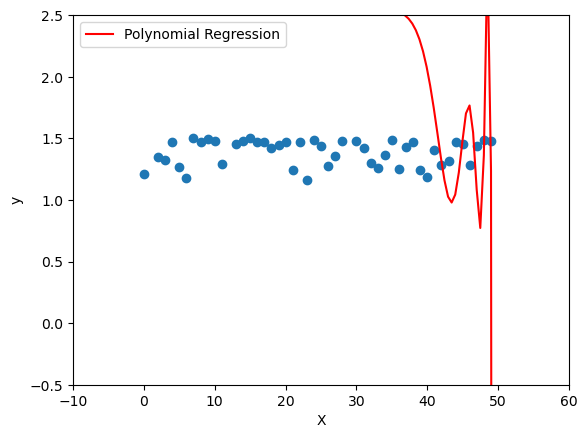

In [70]:
# 다항 회귀 모델 시각화
X_plot = np.linspace(0 ,n, 100).reshape(-1, 1)
X_plot_poly = poly_features.transform(X_plot)
y_plot = model.predict(X_plot_poly)

plt.scatter(np.arange(n), lm/ mu)
plt.xlim(-10,n+10)
plt.ylim(-.5, 2.5)
plt.plot(X_plot, y_plot, color='red', label='Polynomial Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()